# configurações 

In [1]:
%%capture
!pip install keras==2.6.0
!pip install tensorflow==2.3.0
!pip install tensorflow-gpu==2.3.0

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

# importação de bibliotecas 

In [3]:
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [4]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [5]:
print(tf.__version__)

2.3.0


In [6]:
print(tf.config.list_physical_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'), PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Descrição do problema

Em um problema de regressão, o objetivo é prever as saídas (outputs) de um valor contínuo, como um preço ou probabilidade. Em contraste de problemas de classificação, onde temos o propósito de escolher uma classe em uma lista de classificações (por exemplo, se uma imagem contém uma maçã ou laranja, assim reconhecendo qual fruta é representada na imagem).

Este notebook usa a clássica base de dados Auto MPG e constrói um modelo para prever a economia de combustíveis de automóveis do final dos anos 1970, início dos anos 1980. Para isso, forneceremos um modelo com descrição de vários automóveis desse período. Essa descrição inclui atributos como: cilindros, deslocamento, potência do motor, e peso.

# Importação e tratamento dos dados

In [7]:
DATASET_PATH = keras.utils.get_file(
    fname="auto-mpg.data",
    origin="http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")

In [8]:
COLUMNS_NAMES = [
    'MPG'
    'Cylinders',
    'Displacement',
    'Horsepower',
    'Weight',
    'Acceleration',
    'Model Year',
    'Origin'
]

In [9]:
raw_dataset = pd.read_csv(
    DATASET_PATH,
    names=COLUMNS_NAMES,
    na_values = "?",
    comment='\t',
    sep=" ",
    skipinitialspace=True)

raw_dataset = raw_dataset \
    .reset_index() \
    .rename(columns={
        'index': 'MPG',
        'MPGCylinders': 'Cylinders'})

dataset = raw_dataset.copy()

In [10]:
dataset.head(2)

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1


In [11]:
dataset.dtypes

MPG             float64
Cylinders         int64
Displacement    float64
Horsepower      float64
Weight          float64
Acceleration    float64
Model Year        int64
Origin            int64
dtype: object

## Dados nulos

In [12]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [13]:
dataset = dataset.dropna()

## *One hot encoding*

In [14]:
dataset['Origin'] = dataset['Origin'].astype(str)
dataset.loc[:, 'Origin'] = np.where(dataset['Origin']=='1', 'USA', dataset['Origin'])
dataset.loc[:, 'Origin'] = np.where(dataset['Origin']=='2', 'Europe', dataset['Origin'])
dataset.loc[:, 'Origin'] = np.where(dataset['Origin']=='3', 'Japan', dataset['Origin'])

In [15]:
dataset = pd.concat([dataset.drop(columns=['Origin']), pd.get_dummies(dataset['Origin'])], axis=1) 

## Visualização dos dados

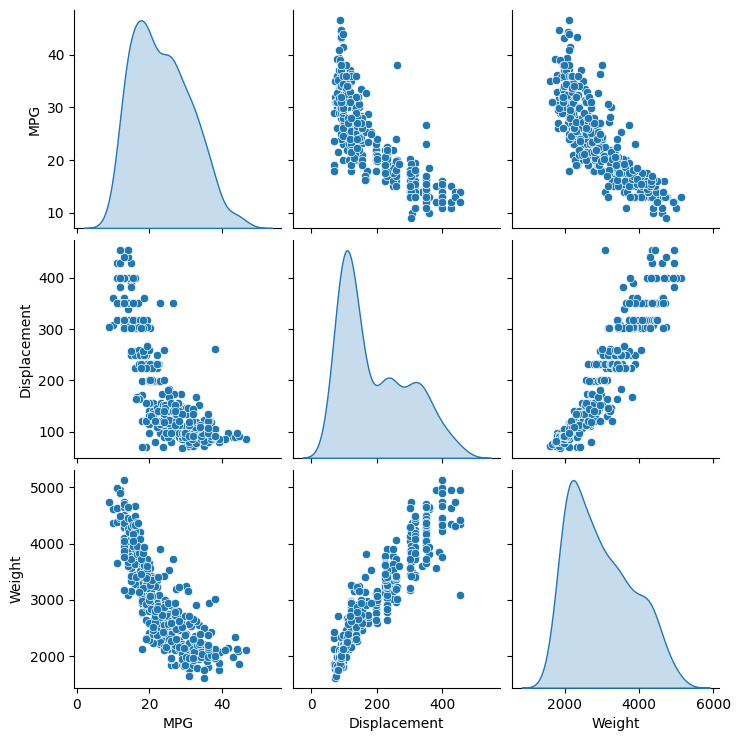

In [16]:
sns.pairplot(
    dataset[["MPG", "Displacement", "Weight"]],
    diag_kind="kde")
plt.show()

## Separação de treino, validação e teste

In [17]:
X_train, sub_X_test, y_train, sub_y_test = train_test_split(
    dataset.drop(columns=['MPG']),
    dataset[['MPG']],
    train_size=0.7,
    random_state=42)

X_val, X_test, y_val, y_test = train_test_split(
    sub_X_test,
    sub_y_test,
    test_size=0.5,
    random_state=42)

In [18]:
print(dataset.shape)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
assert dataset.shape[0] == X_train.shape[0] + X_test.shape[0] + X_val.shape[0]

(392, 10)
(274, 9)
(59, 9)
(59, 9)


## Normalização dos dados

In [19]:
NORM_COLUMNS_NAMES = [
    'MPG'
    'Cylinders',
    'Displacement',
    'Horsepower',
    'Weight',
    'Acceleration',
    'Model Year',
    'USA',
    'Europe',
    'Japan'
]

In [20]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [21]:
X_train_norm = pd.DataFrame(scaler.transform(X_train), columns=NORM_COLUMNS_NAMES)
X_val_norm = pd.DataFrame(scaler.transform(X_val), columns=NORM_COLUMNS_NAMES)
X_test_norm = pd.DataFrame(scaler.transform(X_test), columns=NORM_COLUMNS_NAMES)

In [22]:
print(dataset.shape)
print(X_train_norm.shape)
print(X_val_norm.shape)
print(X_test_norm.shape)
assert dataset.shape[0] == X_train_norm.shape[0] + X_test_norm.shape[0] + X_val_norm.shape[0]

(392, 10)
(274, 9)
(59, 9)
(59, 9)


# Construindo uma rede neural

Há duas formas de se instanciar redes em Keras. Uma delas é instanciando um modelo `Sequential` com uma lista de camadas. A primeira camada da rede precisa receber o parâmetro `input_shape` para que o modelo saiba calcular o número de parâmetros. 

Keras é construido sobre o Tensorflow, Theano ou CNTK, bibliotecas de computação que permitem a utilização de diferentes dispositivos (ex.: CPU, GPU, nós em uma rede) de forma transparente e eficiente.

Quando compilando um modelo, Keras requer que você especifique uma **função de perda**, seu **otimizador** e algumas **métricas**.

O [otimizador](https://keras.io/optimizers) ajuda a determinar o quão rápido um modelo aprende, quão resiliente ele será à "estagnação" ou "explosão" durante o treinamento.

Além disso, podemos definir um número de métricas (como acurácia, MSE, MAE) para observar durante o treinamento.

In [23]:
def build_model(train_dataset):
    
    model = keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])

    model.compile(
        loss='mse',
        optimizer='adam',
        metrics=['mae', 'mse']
    )
    
    return model

In [24]:
ann_1 = build_model(train_dataset=X_train_norm)

In [25]:
ann_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


# Treinando uma rede neural

Essa é a parte divertida: você pode alimentar seu modelo com os dados de treino carregados anteriormente e ele aprenderá predizer a autonomia de cada veículo!

Primeiro, vamos entender os argumentos:
- **X_train & Y_train:** as amostras e rótulos de treino
treino)
- **epochs:** uma época na qual todos os *batches* contidos no conjunto de treino foram processados.
- **verbose:** mostrar as métricas ao fim de cada época
- **class_weight:** os pesos de cada classe, considerando que elas não são balanceadas. Isso irá ponderar a perda baseando-se em quão frequente cada classe é
- **validation_data:** ao final de cada época, nosso modelo é utilizado para predizer este conjunto e exibir o valor de perda e métricas especificadas.

***batch_size:** em vez de otimizar os parâmetros da rede sobre todo o conjunto de treino, nós usualmente atualizamos a cada *batch* (pequenas amostras do conjunto de 

In [26]:
history  = ann_1.fit(
    X_train_norm,
    y_train,
    epochs=1000,
    verbose=1, 
    validation_data=(X_val_norm, y_val))

Epoch 1/1000
9/9 [==============================] - 0s 20ms/step - loss: 605.0909 - mae: 23.2667 - mse: 605.0909 - val_loss: 570.5618 - val_mae: 22.6992 - val_mse: 570.5618
Epoch 2/1000
9/9 [==============================] - 0s 4ms/step - loss: 569.6714 - mae: 22.5021 - mse: 569.6714 - val_loss: 532.9684 - val_mae: 21.8640 - val_mse: 532.9684
Epoch 3/1000
9/9 [==============================] - 0s 8ms/step - loss: 529.7157 - mae: 21.6128 - mse: 529.7157 - val_loss: 488.7660 - val_mae: 20.8394 - val_mse: 488.7660
Epoch 4/1000
9/9 [==============================] - 0s 4ms/step - loss: 480.8906 - mae: 20.4831 - mse: 480.8906 - val_loss: 434.0388 - val_mae: 19.5094 - val_mse: 434.0388
Epoch 5/1000
9/9 [==============================] - 0s 8ms/step - loss: 421.0150 - mae: 19.0020 - mse: 421.0150 - val_loss: 366.5428 - val_mae: 17.7625 - val_mse: 366.5428
Epoch 6/1000
9/9 [==============================] - 0s 8ms/step - loss: 346.5724 - mae: 17.0354 - mse: 346.5724 - val_loss: 287.5413 - val_

# Avaliando a performance do modelo 

In [27]:
score = ann_1.evaluate(X_test_norm, y_test, verbose=1)
print('Test loss', np.round(score[0], 3))
print('Test mae', np.round(score[1], 3))
print('Test mse', np.round(score[2], 3))

2/2 [==============================] - 0s 1ms/step - loss: 8.3859 - mae: 2.0677 - mse: 8.3859
Test loss 8.386
Test mae 2.068
Test mse 8.386


Podemos exibir o histórico do treinamento do modelo acessando `model.history`.

In [28]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,2.366891,0.922467,2.366891,6.725029,1.968132,6.725029,995
996,2.457137,0.953956,2.457137,6.602400,1.904717,6.602400,996
997,2.339165,0.910530,2.339165,6.552128,1.914638,6.552128,997
998,2.389143,0.927951,2.389143,6.676698,1.931752,6.676698,998
999,2.319991,0.903395,2.319991,6.574014,1.944895,6.574014,999


In [29]:
def plot_history(history):
    
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure(figsize=(20,4))
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(
        hist['epoch'],
        hist['mae'],
        label='Train Error')
    plt.plot(
        hist['epoch'],
        hist['val_mae'],
        label = 'Val Error')
    plt.ylim([0,5])
    plt.grid(alpha=0.25)
    plt.legend()

    plt.figure(figsize=(20,4))
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$MPG^2$]')
    plt.plot(
        hist['epoch'],
        hist['mse'],
        label='Train Error')
    plt.plot(
        hist['epoch'],
        hist['val_mse'],
        label = 'Val Error')
    plt.ylim([0,20])
    plt.legend()
    plt.grid(alpha=0.25)
    plt.show()

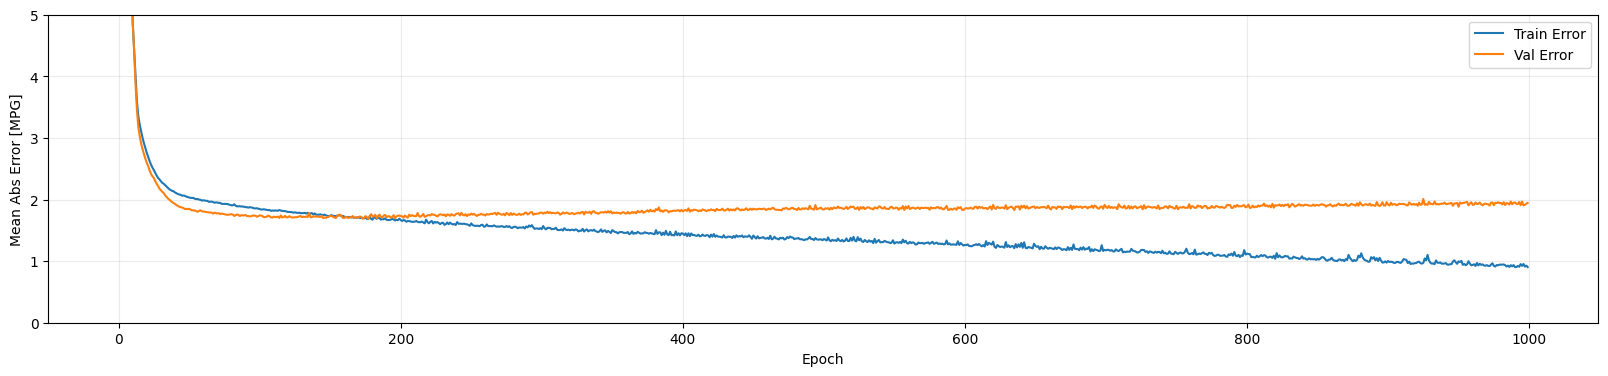

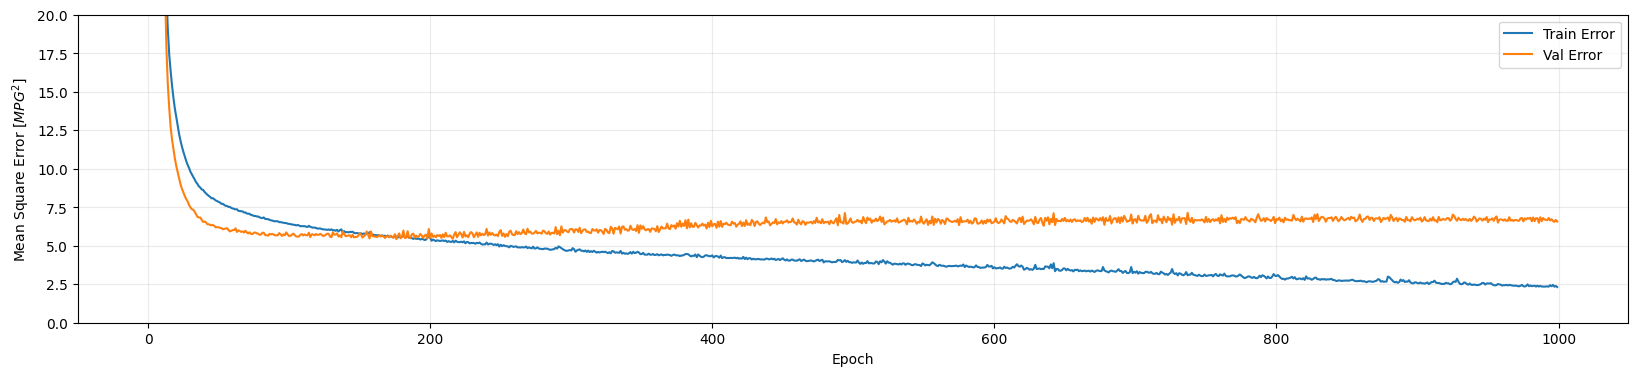

In [30]:
plot_history(history)

## *Early stopping* 

Este gráfico mostra as pequenas melhoras, ou mesmo a diminuição do **validation error** após algumas épocas epochs. Vamos atualizar o `model.fit` para que pare automaticamente o treinamento quando o **validation score** não aumentar mais. Usaremos o `EarlyStopping callback` que testa a condição do treinamento a cada **epoch**. Se um grupo de **epochs** decorre sem mostrar melhoras, o treinamento irá parar automaticamente. 

In [31]:
ann_2 = build_model(train_dataset=X_train_norm)

In [32]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)

In [33]:
history  = ann_2.fit(
    X_train_norm,
    y_train,
    epochs=1000,
    verbose=1, 
    validation_data=(X_val_norm, y_val),
    callbacks=early_stop)

Epoch 1/1000
9/9 [==============================] - 0s 18ms/step - loss: 611.8373 - mae: 23.4343 - mse: 611.8373 - val_loss: 576.6749 - val_mae: 22.8616 - val_mse: 576.6749
Epoch 2/1000
9/9 [==============================] - 0s 6ms/step - loss: 577.7897 - mae: 22.7237 - mse: 577.7897 - val_loss: 541.4136 - val_mae: 22.0958 - val_mse: 541.4136
Epoch 3/1000
9/9 [==============================] - 0s 3ms/step - loss: 540.8530 - mae: 21.9121 - mse: 540.8530 - val_loss: 499.7041 - val_mae: 21.1579 - val_mse: 499.7041
Epoch 4/1000
9/9 [==============================] - 0s 8ms/step - loss: 494.1972 - mae: 20.8743 - mse: 494.1972 - val_loss: 445.6525 - val_mae: 19.8917 - val_mse: 445.6525
Epoch 5/1000
9/9 [==============================] - 0s 8ms/step - loss: 433.0052 - mae: 19.4275 - mse: 433.0052 - val_loss: 377.1208 - val_mae: 18.1633 - val_mse: 377.1208
Epoch 6/1000
9/9 [==============================] - 0s 3ms/step - loss: 357.4594 - mae: 17.4712 - mse: 357.4594 - val_loss: 295.2811 - val_

In [34]:
score = ann_2.evaluate(X_test_norm, y_test, verbose=1)
print('Test loss:', np.round(score[0], 3))
print('Test mae:', np.round(score[1], 3))
print('Test mse:', np.round(score[2], 3))

2/2 [==============================] - 0s 1ms/step - loss: 7.5750 - mae: 1.9493 - mse: 7.5750
Test loss: 7.575
Test mae: 1.949
Test mse: 7.575


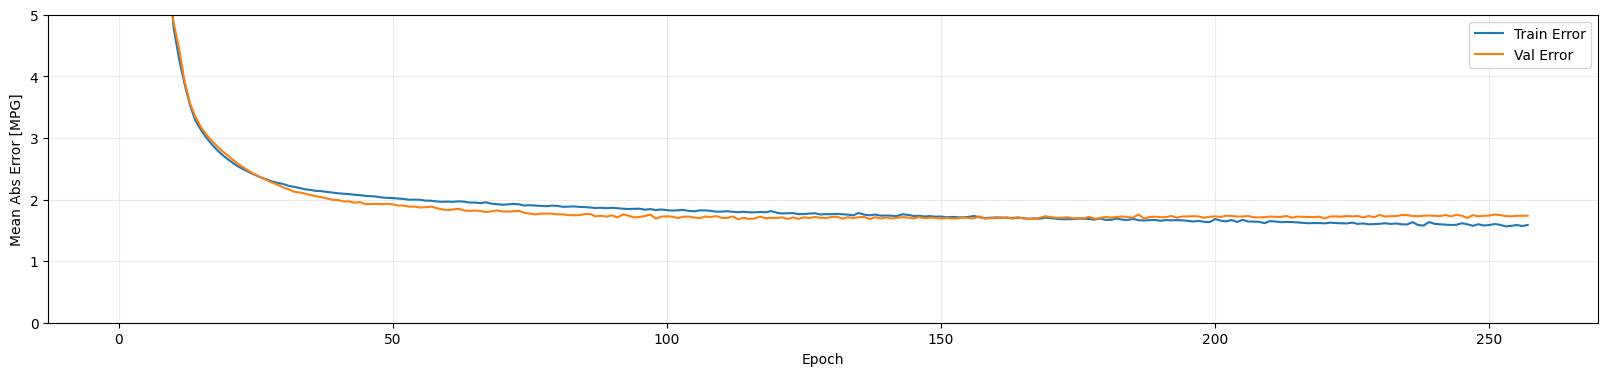

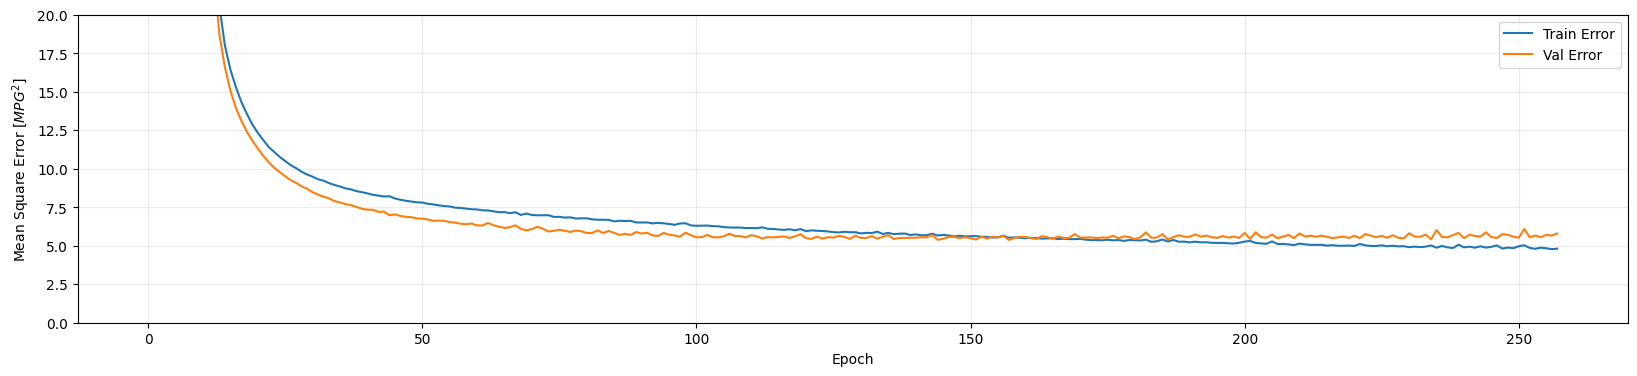

In [35]:
plot_history(history)

# Fazendo predições

In [36]:
test_predictions = ann_2.predict(X_test_norm).flatten()

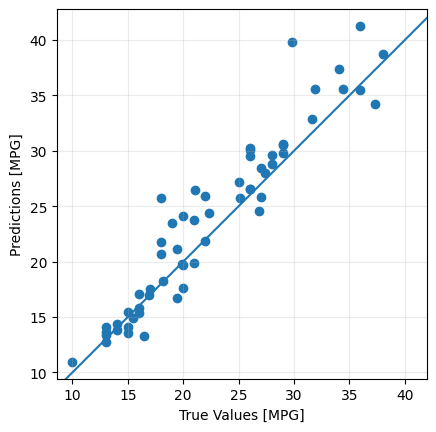

In [37]:
plt.scatter(y_test, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
_ = plt.plot([-100, 100], [-100, 100])
plt.grid(alpha=0.25)
plt.show()

# Referências 

[1] https://www.tensorflow.org/tutorials/keras/regression#base_de_dados_auto_mpg

[2] https://github.com/wxs/keras-mnist-tutorial/blob/master/MNIST%20in%20Keras.ipynb